# Customer Segmentation
Customer Segmentation is the process of dividing a customer base into distinct groups based on shared characteristics such as demographics, purchasing behavior, or engagement patterns. The goal is to identify meaningful patterns within customer data that can inform targeted marketing strategies, personalized experiences, and resource allocation. Effective segmentation allows businesses to better understand their customer base, optimize product offerings, and improve customer retention.

## Importing Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv('segmentation_data.csv', delimiter='\t')
df = pd.DataFrame(dataset)
df.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

Our dataset is organized in a tab-delimited CSV where each row is a customer and each column is an attribute. Some features aren't self-explanatory: 
- Education: Education level the customer reached\
- Kidhome: Kids in household\
- Teenhome: Teens in household\
- Dt_Customer: Date customer first purchased\
- MntXXXXXXX: Amount customer has spent in category XYZ

Looking at the data, some columns are irrelavant: AcceptedCmp1-5 all have priamrily 0 values, Dt_Customer is more valuable for time-series analysis, Response and Complain are binary values that describe whether a customer has complained and if a response was made, Z_CostContact and Z_Revenue describe the cost of contacting the customer and the revenue they have generated. For our segmentation purposes, we will eliminate these columns.

# Preprocessing

### Drop Unnecessary Data

In [3]:
columns_to_drop = [
    'Dt_Customer', 
    'AcceptedCmp1', 
    'AcceptedCmp2', 
    'AcceptedCmp3', 
    'AcceptedCmp4', 
    'AcceptedCmp5', 
    'Response', 
    'Complain', 
    'Z_CostContact', 
    'Z_Revenue'
]

dropped_df = df.drop(columns=[col for col in columns_to_drop])

In [4]:
dropped_df.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
dtype: object

### Encode Categorical Data

In [5]:
# Exploring 'object' type columns
for col in dropped_df.select_dtypes(include='object').columns:
    print(f'{col}: {dropped_df[col].unique()}')

Education: ['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']
Marital_Status: ['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']


In [6]:
# Encoding 'Education' and 'Marital_Status' columns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer(transformers=[('encoded', OneHotEncoder(), ['Education', 'Marital_Status'])], remainder='passthrough')
X = ct.fit_transform(dropped_df)

### NaN Imputing

In [7]:
# Checking for NaN values
nan_indices = np.isnan(X) # Check for NaNs
nan_per_column = np.sum(nan_indices, axis=0) # Sum NaNs per column
column_names = ct.get_feature_names_out() # Get col names
for col_index, count in enumerate(nan_per_column):
    if count > 0:
        print(f"Column '{column_names[col_index]}' has {count} NaN values.")

Column 'remainder__Income' has 24 NaN values.


In [8]:
# Imputing NaN values
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

### Feature Scaling

In [9]:
# Scaling the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Clustering

The primary clustering methods are hierarchical and k-means clustering. They're both unsupervised methods used for grouping data into clusters, but they differ in approach and use cases.
- Hierarchical clustering builds a tree-like structure called a dendrogram to represent data points and their relationships. It starts by treating each data point as its own cluster, then iteratively merges the closest clusters based on a distance metric until only one cluster remains. It doesn’t require the number of clusters to be specified beforehand and provides a visual way to determine the optimal number of clusters. However, it can be computationally expensive, especially for large datasets due to its O(n^2) complexity.
- K-Means clustering partitions data into a predefined number of clusters (k). It initializes k centroids randomly and iteratively assigns points to the nearest centroid, updating the centroids based on the mean of assigned points until convergence. K-Means is faster and more scalable for large datasets but requires the number of clusters to be defined beforehand and can be sensitive to the initial centroid placement.

We will also use PCA to reduce the dimensionality of our input data so it can be visualized easily.

### K-Means

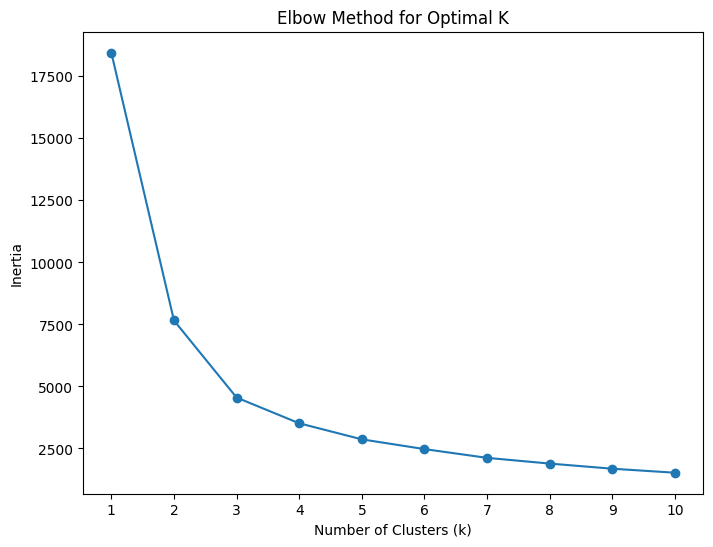

In [ ]:
# Elbow method and PCA
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Apply PCA to reduce input to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

inertia = []
k_values = range(1, 11)  # Trying k from 1 to 10

# Elbow method
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method results
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.show()

Looks like 3 is the optimal k. 5 could also work.

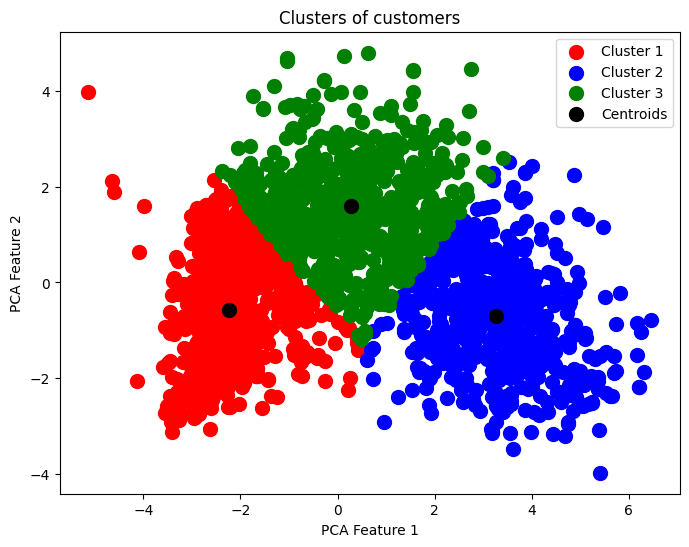

In [11]:
# K-Means Clustering
optimal_k = 3
optimal_kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
y_kmeans = optimal_kmeans.fit_predict(X_pca) # Input is already in 2D

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y_kmeans == 0, 0], X_pca[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X_pca[y_kmeans == 1, 0], X_pca[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X_pca[y_kmeans == 2, 0], X_pca[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
centroids = optimal_kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], s = 100, c = 'black', label = 'Centroids')
plt.title('Clusters of customers')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.legend()
plt.show()

### Hierarchical

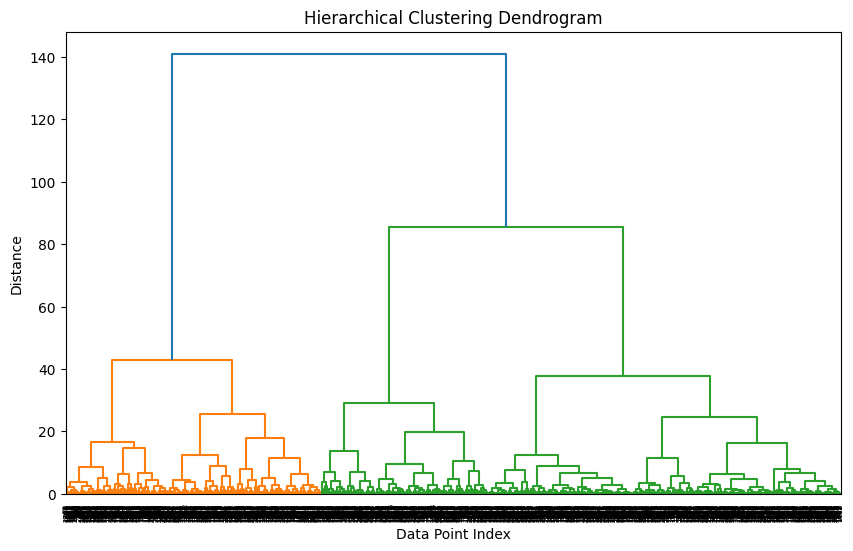

In [13]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Compute the linkage matrix for the dendrogram
linkage_matrix = linkage(X_pca, method='ward')
hierarchical_model = AgglomerativeClustering(n_clusters=3, linkage='ward')
hierarchical_labels = hierarchical_model.fit_predict(X_pca)

# Plotting the Dendrogram for Hierarchical Clustering
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Data Point Index")
plt.ylabel("Distance")
plt.show()